In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


Little bit of data wrangling here, pandas loads the csv as a dataframe, but scikit learn wants numpy arrays and pytorch needs them to be tensors for actual training.

In [2]:

dataset= pd.read_csv("Cleaned_data.csv")
# Need to clean the nans from the dataset so the tensors play well with it
# last minute because I couldn't make the tensors
dataset = dataset.select_dtypes(include='number').dropna()
X= dataset.drop(["Beats_spy"], axis=1)
y= dataset["Beats_spy"]





# print(X.info(), y.info())
# converting to np arrays because scikit learn expects those
X= np.array(X)
y= np.array(y)
y= y.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=16)
# print (len(X_train), len(X_test), len(y_train), len(y_test))
# now converting those to tensors to finally be able to put them into the model
X_train_tensor= torch.tensor(X_train, dtype=torch.float32)
y_train_tensor= torch.tensor(y_train, dtype=torch.float32)

X_test_tensor= torch.tensor(X_test, dtype=torch.float32)
y_test_tensor= torch.tensor(y_test, dtype=torch.float32)

In [3]:
# 
class MLP(torch.nn.Module):
    def __init__(self, layer_size, num_layers=2,  input_count=9):
        # doesn't work without this
        super().__init__()
        layers=[]
        prev_size= input_count
        for i in range(num_layers):
            curr_size= layer_size
            layers.append(nn.Linear(prev_size,curr_size))
            prev_size= curr_size
            layers.append(nn.ReLU())
        # this is a binary classification so we want the final Layer's output to be True/false
        layers.append(nn.Linear(prev_size, 1))
        self.model= nn.Sequential(*layers)
    def forward(self, X):
        return self.model(X)

In [4]:
def train_model(model, X, y, epochs=3, lr=0.001):
    # I would not recommnend running this locally without cuda it takes forever
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    criterion= nn.BCEWithLogitsLoss()
    optimizer= optim.Adam(model.parameters(), lr)
    model.train()
    model.to(device)
    for i in range(epochs):
        print(F"Currently on batch {i}")
        group_loss= 0.0
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            outputs= model(batch_x).squeeze()
            loss = criterion(outputs, batch_y)
            # Conveniently, the backpropagation is an inbuilt at least
            loss.backward()
            optimizer.step()
            group_loss += loss.item()



In [5]:
test_model= MLP(10,10)
train_model(test_model, X_train_tensor, y_train_tensor)



Currently on batch 0
Currently on batch 1
Currently on batch 2


In [59]:
test_model.eval()

MLP(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=11, bias=True)
    (1): ReLU()
    (2): Linear(in_features=11, out_features=6, bias=True)
    (3): ReLU()
    (4): Linear(in_features=6, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=3, bias=True)
    (7): ReLU()
    (8): Linear(in_features=3, out_features=3, bias=True)
    (9): ReLU()
    (10): Linear(in_features=3, out_features=2, bias=True)
    (11): ReLU()
    (12): Linear(in_features=2, out_features=2, bias=True)
    (13): ReLU()
    (14): Linear(in_features=2, out_features=2, bias=True)
    (15): ReLU()
    (16): Linear(in_features=2, out_features=2, bias=True)
    (17): ReLU()
    (18): Linear(in_features=2, out_features=2, bias=True)
    (19): ReLU()
    (20): Linear(in_features=2, out_features=1, bias=True)
  )
)

Big problem here, as you'll see soon- the model weights haven't changed at all. That is, they are all identical, and running the predict function gives us a single value (the default one on initialization). Most likely, it's a product of the few epochs+ the small number of explanatory variables available, since there are really only 2 values in the dataset, and it's pretty unlikely we'll be able to predict year long price trends based on a single day of data. The small number of epochs should be mentioned too- ideally, I'd give it more time and also run ray tune to change the hyperparameters to see if that changed anything, but this is unfeasible for time reasons- I have never been able to train a model with more than 3 epochs, and even at that small number it takes 11 minutes (with gpu acceleration enabled, too). Ideally, I'd run a bunch of models and try and narrow down performance, but this is simply technically unfeasible with the equipment and timeframe I have.

In [ ]:


with torch.no_grad():
    X_test_tensor= X_test_tensor.to(device="cuda")
    y_test_tensor= y_test_tensor.to(device="cuda")
    predictions= test_model(X_test_tensor)
    not_logits= torch.sigmoid(predictions)
    float_preds=(not_logits>0.5).float()

    # print(score(predictions, y_test_tensor))
    # print(predictions.unique())

In [13]:
def score(predictions, actual):
    total_right=0
    for prediction, actual_val in zip(predictions,actual):
        if prediction== actual_val:
            total_right+=1
    return total_right/len(actual)
print(score(float_preds, y_test))
# print(y_test[0], float_preds[0])
# print(y_test[0]==float_preds[0])

0.64504793372877


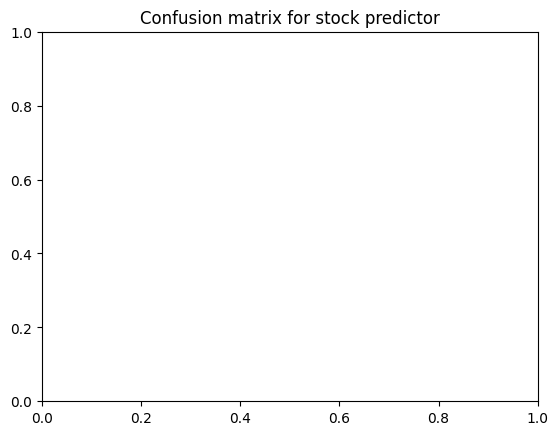

In [ ]:
float_preds_is_stuck_in_cuda= float_preds.cpu().numpy()
confusion = confusion_matrix(y_test, float_preds_is_stuck_in_cuda)
print(confusion)
plot_matrix = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["doesn't beat", "Beats"])
plt.title("Confusion matrix for stock predictor")
plt.show()
